# Segmenting and Clustering Neighborhoods in Toronto  
*Final Assignment*

## Introduction/Business Problem   
### Discussion of the problem: “Which of Toronto neighborhood is the most ideal to start a new Spiritual Development Center?” 
My Canadian client devoted to the problem of spiritual growth and personal development is interested to open the Spiritual Development Center in Toronto. She believes that the Center should be situated in the area popular within active people, involved in sport and a healthy lifestyle.  She also thinks that restaurants and coffee shops might negatively affect the spiritual growth of her future students, so the ideal neighborhood for the Center should contain less restaurants than venues related to the active lifestyle. 
My client asks wants me to consult him on which locality or neighborhood of Toronto is best suited to start the Spiritual Development Center. 
### Target Audience  
Similarly to my client, other businesses can be interested to know which Toronto neighborhoods attract active people. These information can be used for new venue openings and for advertisement targeting of such venues as sport goods shops, healthy food shops, nutritionists, supplement shops, alternative medicine centers and others.


**Before we get the data and start exploring it, let's download all the dependencies that we will need.**

In [9]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
mpl.style.use('ggplot') # optional: for ggplot-like style

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

!conda install -c conda-forge BeautifulSoup4 --yes
from bs4 import BeautifulSoup as soup # library to parse HTML and XML documents

!conda install -c conda-forge xlrd --yes  # library to load Excel files

# install wordcloud
!conda install -c conda-forge wordcloud==1.4.1 --yes  # make a word cloud
from wordcloud import WordCloud, STOPWORDS

print("Libraries imported.")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages 

## Dataset 1: 
List of postal codes of Toronto along with the boroughs and neighborhoods 
Since we focus on Toronto in this project, we will be looking to procure all the demographic information related to city, including all the boroughs and neighborhoods of Toronto along with their associated zip code.   
To do this, we rely on the publicly available Wikipedia page titled "List of postal codes of Canada:_M" 
As can be seen from the description of the page:  
“Postal codes beginning with M are located within the city of Toronto in the province of Ontario.”  
We will be scraping this data from the Wikipedia page with the help of Python’s pandas and Wikipedia packages.  


**Scrap data from Wikipedia page into a DataFrame**

In [10]:
# send the GET request
data = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
# parse data from the html into a beautifulsoup object
soup = soup(data, 'html.parser')
# create three lists to store table data
postalCodeList = []
boroughList = []
neighborhoodList = []


# find the table
soup.find('table').find_all('tr')

# find all the rows of the table
soup.find('table').find_all('tr')

# for each row of the table, find all the table data
for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    
    # append the data into the respective lists
for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    if(len(cells) > 0):
        postalCodeList.append(cells[0].text)
        boroughList.append(cells[1].text)
        neighborhoodList.append(cells[2].text.rstrip('\n')) # avoid new lines in neighborhood cell
        
# create a new DataFrame from the three lists
toronto_df = pd.DataFrame({"PostalCode": postalCodeList,
                           "Borough": boroughList,
                           "Neighborhood": neighborhoodList})

toronto_df.head()        

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [11]:
toronto_df.shape

(288, 3)

**Drop cells with a borough that is "Not assigned", group neighborhoods in the same borough, for Neighborhood="Not assigned", make the value the same as Borough**

In [14]:
# drop cells with a borough that is Not assigned
toronto_df_dropna = toronto_df[toronto_df.Borough != "Not assigned"].reset_index(drop=True)
print(toronto_df_dropna.shape)

# group neighborhoods in the same borough
toronto_df_grouped = toronto_df_dropna.groupby(["PostalCode", "Borough"], as_index=False).agg(lambda x: ", ".join(x))

# for Neighborhood="Not assigned", make the value the same as Borough
for index, row in toronto_df_grouped.iterrows():
    if row["Neighborhood"] == "Not assigned":
        row["Neighborhood"] = row["Borough"]
print(toronto_df_grouped.shape)        
toronto_df_grouped.head()

(211, 3)
(103, 3)


,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


## Dataset 2: 
Geographical co-ordinates of the neighborhoods  
In order to plot the neighborhoods on the map, we will also be using the geographical co-ordinates of the neighborhoods of Toronto. Although this data can be obtained using the Google Maps Geocoding API, given the unreliability of the package we use data from the following source: http://cocl.us/Geospatial_data 

**Load the coordinates from the csv file on Coursera**

In [15]:
# load the coordinates from the csv file on Coursera
coordinates = pd.read_csv("https://cocl.us/Geospatial_data")

# rename the column "PostalCode"
coordinates.rename(columns={"Postal Code": "PostalCode"}, inplace=True)
coordinates.head()


,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


**Merge two tables**

In [17]:
# merge two table on the column "PostalCode"
toronto_df_new = toronto_df_grouped.merge(coordinates, on="PostalCode", how="left")
print(toronto_df_new.shape)
toronto_df_new.head()

(103, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


**Use geopy library to get the latitude and longitude values of Toronto**

In [18]:
address = 'Toronto'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The Toronto coordinates are {}, {}.'.format(latitude, longitude))


The Toronto coordinates are 43.653963, -79.387207.


## Dataset 3:
Data called from through Foursquare API 
In this project, we will be leveraging the Foursquare API to obtain the geographical location data of various neighborhoods of Toronto. This data will be used to explore the popular and commonly visited venues in each of the neighborhoods, which will help us to identify the best possible location for our client’s Indian restaurant.   
We will redefine venues categories to satisfy the client’s requirement as *“Food provider”*, *“Health provider”* and *“Indifferent"* venue.  


**Use the Foursquare API to explore the neighborhoods**

In [19]:
# define Foursquare Credentials and Version
CLIENT_ID = 'HDRCNIBGBGBFUSDSE0ET5PYSHRTVHPYN5DPVUK3UISSLMEAE' # your Foursquare ID
CLIENT_SECRET = 'PYB0N3UGBXRO0LOUIVZM4X0JAHGEIISGSNIVUOPOLZKZTHRT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HDRCNIBGBGBFUSDSE0ET5PYSHRTVHPYN5DPVUK3UISSLMEAE
CLIENT_SECRET:PYB0N3UGBXRO0LOUIVZM4X0JAHGEIISGSNIVUOPOLZKZTHRT


In [99]:
radius = 500
LIMIT = 300

venues = []

for lat, long, post, borough, neighborhood in zip(toronto_df_new['Latitude'], toronto_df_new['Longitude'], toronto_df_new['PostalCode'], toronto_df_new['Borough'], toronto_df_new['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            post, 
            borough,
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [100]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['PostalCode', 'Borough', 'Neighborhood', 'BoroughLatitude', 'BoroughLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(2233, 9)


,PostalCode,Borough,Neighborhood,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,RIGHT WAY TO GOLF,43.785177,-79.161108,Golf Course
2,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Affordable Toronto Movers,43.787919,-79.162977,Moving Target
4,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place


In [101]:
print('There are {} unique categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 274 unique categories.


**Redefine venues categories to satisfy the client’s requirement as “Food provider”, “Health provider” and “Indifferent” venues**

**"Food Providers" are Restaurants, Coffee Shops, Bars etc**

In [102]:
venues_cat = venues_df['VenueCategory'].unique()

venues_food = []

# restaurants
for x in venues_cat:
    if "restaurant" in x.lower():
        venues_food.append(x)       

# coffee shops
for x in venues_cat:
    if "coffee" in x.lower() or "spot" in x.lower():
        venues_food.append(x)
        
for x in venues_cat:
    if ("caf" in x.lower()) and not ("gaming" in x.lower()):
        venues_food.append(x)
        
# other food mentioned
for x in venues_cat:
    if "snack" in x.lower() or "bistro" in x.lower() or "pizza" in x.lower() or "place" in x.lower() or "joint" in x.lower()  or "noodle" in x.lower() or "cupcake" in x.lower()  or "candy" in x.lower():
        venues_food.append(x)

for x in venues_cat:
    if "bakery" in x.lower() or "food court" in x.lower() or "ice cream" in x.lower() or "diner" in x.lower() or "steakhouse" in x.lower()  or "gastropub" in x.lower() or "creperie" in x.lower()  or "tea" in x.lower():
        venues_food.append(x)        

for x in venues_cat:
    if "beer" in x.lower() or "brewery" in x.lower() or "liquor" in x.lower() or "deli" in x.lower()  or "cheese" in x.lower() or "dessert" in x.lower():
        venues_food.append(x)
        
for x in venues_cat:
    if "fish & chips" in x.lower() or "pub" in x.lower() or "speakeasy" in x.lower():
        venues_food.append(x)        
        
for x in venues_cat:
    if "market" in x.lower() and not "flea" in x.lower():
        venues_food.append(x)
        
for x in venues_cat:
    if "bar" in x.lower() and not "barbershop" in x.lower():
        venues_food.append(x)
        
for x in venues_cat:
    if "food" in x.lower()  and not "health" in x.lower():
        venues_food.append(x)
        
for x in venues_cat:
    if "grocery" in x.lower()   and not "organic" in x.lower():
        venues_food.append(x)

my_set = set(venues_food)
venues_food = list(my_set)
print(len(venues_food))

113


**Considering all "active living" venues as "Health Providers". In addition, organic food stores and smoothie bars are defined as "Health Providers"D**

In [103]:
venues_healthy_life = []

for x in venues_cat:
    if "health" in x.lower() or "gym" in x.lower() or "field" in x.lower() or "park" in x.lower() or "stadium" in x.lower():
        venues_healthy_life.append(x)

for x in venues_cat:
    if ("sport" in x.lower()) and not ("bar" in x.lower()):
        venues_healthy_life.append(x)
        
for x in venues_cat:
    if ("court" in x.lower()) and not ("food" in x.lower()):
        venues_healthy_life.append(x)
        
for x in venues_cat:
    if ("studio" in x.lower()) and not ("recording" in x.lower()):
        venues_healthy_life.append(x)
        
for x in venues_cat:
    if "supplement" in x.lower() or "smoothie" in x.lower() or "organic" in x.lower():
        venues_healthy_life.append(x)
        
for x in venues_cat:
    if "skat" in x.lower() or "pool" in x.lower() or "swim" in x.lower()  or "bike" in x.lower()  or "trail" in x.lower()  or "arena" in x.lower():
        venues_healthy_life.append(x)
        
my_set = set(venues_healthy_life)
venues_healthy_life = list(my_set)
print(len(venues_healthy_life))


31


**Add new categories to the Venues dataframe** 

In [104]:
venues_foodie = []
for f in venues_df['VenueCategory']:
    if f in venues_food:
        venues_foodie.append('Food Provider')
    elif f in venues_healthy_life:
        venues_foodie.append('Health Provider')
    else:
        venues_foodie.append('Indifferent') 

In [105]:
venues_df['FoodHealth'] = venues_foodie
venues_df.head()

,PostalCode,Borough,Neighborhood,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory,FoodHealth
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant,Food Provider
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,RIGHT WAY TO GOLF,43.785177,-79.161108,Golf Course,Indifferent
2,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar,Food Provider
3,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Affordable Toronto Movers,43.787919,-79.162977,Moving Target,Indifferent
4,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place,Food Provider


In [106]:
venues_df.shape

(2233, 10)

**Visualize original venue categories as three wordcloud objects accordingly to three redefined categories.**

In [107]:
category_groups = pd.DataFrame({'VenueCategory':venues_df['VenueCategory'],
                               'FoodHealth':venues_df['FoodHealth']})

category_groups.head()

,VenueCategory,FoodHealth
0,Fast Food Restaurant,Food Provider
1,Golf Course,Indifferent
2,Bar,Food Provider
3,Moving Target,Indifferent
4,Pizza Place,Food Provider


In [108]:
# list original catergories
food_words = list(category_groups.loc[category_groups['FoodHealth']=='Food Provider', category_groups.columns[0]])
health_words = list(category_groups.loc[category_groups['FoodHealth']=='Health Provider', category_groups.columns[0]])
other_words = list(category_groups.loc[category_groups['FoodHealth']=='Indifferent', category_groups.columns[0]])

# join lists of words to strings
food_str = ' '.join(food_words)
health_str = ' '.join(health_words)
other_str = ' '.join(other_words)

stopwords = set(STOPWORDS)

**Define the word clouds colors**


In [109]:
def random_red_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = np.random.randint(0, 25)
    s = np.random.randint(80, 100)
    l = np.random.randint(40, 70)

    return "hsl({}, {}%, {}%)".format(h, s, l)

def random_green_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = np.random.randint(90, 150)
    s = np.random.randint(70, 100)
    l = np.random.randint(20, 60)

    return "hsl({}, {}%, {}%)".format(h, s, l)

def random_blue_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = np.random.randint(180, 270)
    s = np.random.randint(50, 100)
    l = np.random.randint(20, 60)

    return "hsl({}, {}%, {}%)".format(h, s, l)

In [110]:
# instantiate a word cloud object
food_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords,
    color_func=random_red_color_func)

# generate the word cloud
food_wc.generate(food_str)

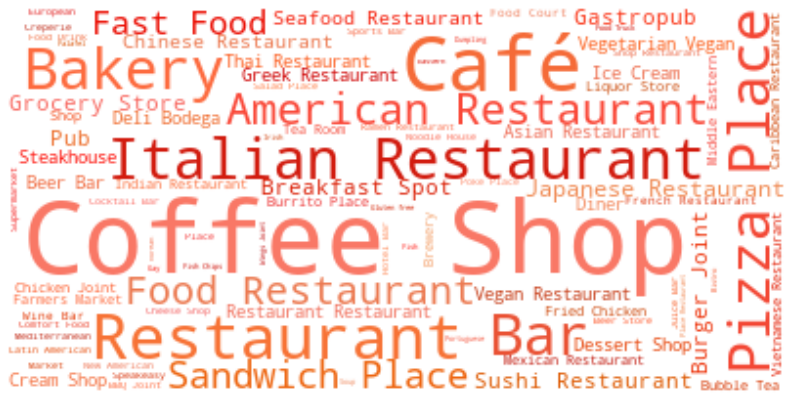

In [111]:
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(14) # set height

# display the cloud
plt.imshow(food_wc, interpolation='bilinear')
plt.axis('off')
plt.savefig("food_cloud.png", format="png")

plt.show()


In [112]:
# instantiate a word cloud object
health_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords,
    color_func=random_green_color_func)

# generate the word cloud
health_wc.generate(health_str)

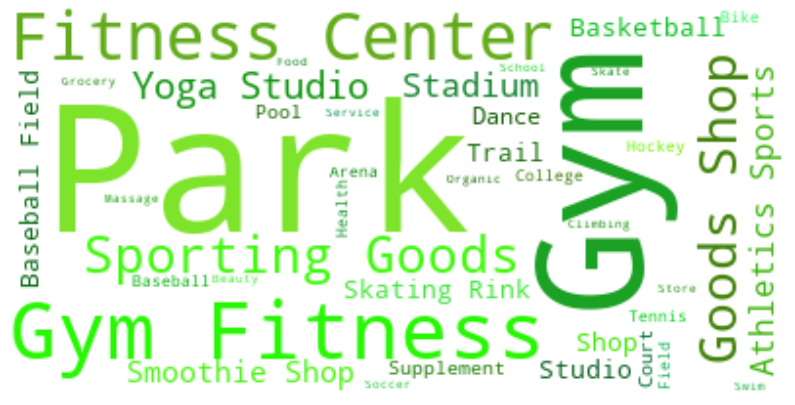

In [113]:
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(14) # set height

# display the cloud
plt.imshow(health_wc, interpolation='bilinear')
plt.axis('off')
plt.savefig("health_cloud.png", format="png")

plt.show()

In [114]:
# instantiate a word cloud object
other_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords,
    color_func=random_blue_color_func)

# generate the word cloud
other_wc.generate(other_str)

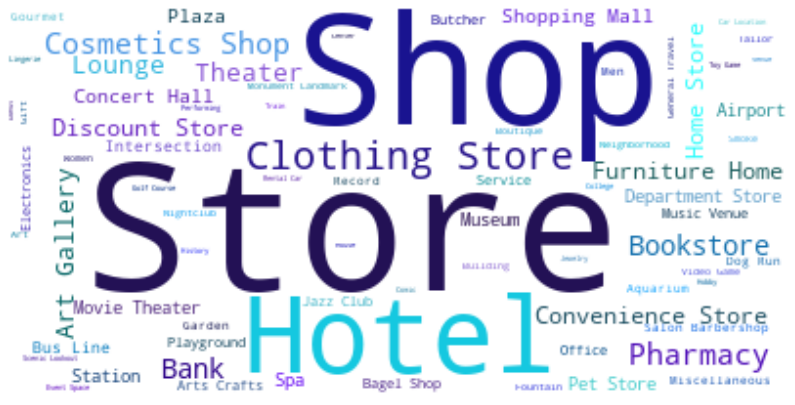

In [115]:
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(14) # set height

# display the cloud
plt.imshow(other_wc, interpolation='bilinear')
plt.axis('off')
plt.savefig("others_cloud.png", format="png")

plt.show()

## Generate new dataframe for the neighborhoods clustering 

In [116]:
# one hot encoding
toronto_onehot = pd.get_dummies(venues_df[['FoodHealth']], prefix="", prefix_sep="")

# add postal, borough and neighborhood column back to dataframe
toronto_onehot['PostalCode'] = venues_df['PostalCode'] 
toronto_onehot['Borough'] = venues_df['Borough'] 
toronto_onehot['Neighborhoods'] = venues_df['Neighborhood'] 

# move postal, borough and neighborhood column to the first column
fixed_columns = list(toronto_onehot.columns[-3:]) + list(toronto_onehot.columns[:-3])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(2233, 6)


,PostalCode,Borough,Neighborhoods,Food Provider,Health Provider,Indifferent
0,M1B,Scarborough,"Rouge, Malvern",1,0,0
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",0,0,1
2,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",1,0,0
3,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",0,0,1
4,M1E,Scarborough,"Guildwood, Morningside, West Hill",1,0,0


### Group rows by neighborhood and by taking the frequency of occurrence of each category and visualize as scatter lot 

In [117]:
venues_grouped = toronto_onehot.groupby(["PostalCode", "Borough", "Neighborhoods"]).sum().reset_index()
print(venues_grouped.shape)
venues_grouped.head()

(101, 6)


,PostalCode,Borough,Neighborhoods,Food Provider,Health Provider,Indifferent
0,M1B,Scarborough,"Rouge, Malvern",1,0,0
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",1,0,2
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",3,0,4
3,M1G,Scarborough,Woburn,3,0,0
4,M1H,Scarborough,Cedarbrae,5,1,1


In [118]:
venues_grouped['Venues'] = venues_grouped['Food Provider'] + venues_grouped['Health Provider'] + venues_grouped['Indifferent']
venues_grouped.head()

,PostalCode,Borough,Neighborhoods,Food Provider,Health Provider,Indifferent,Venues
0,M1B,Scarborough,"Rouge, Malvern",1,0,0,1
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",1,0,2,3
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",3,0,4,7
3,M1G,Scarborough,Woburn,3,0,0,3
4,M1H,Scarborough,Cedarbrae,5,1,1,7


**Define neighborhood colors by the Borough**

In [119]:
colours = {'Central Toronto':'#26547C', 
                 'Downtown Toronto':'red', 
                 'East Toronto':'#06D6A0',
                 'Etobicoke':'#A14A76', 
                 'Mississauga':'#81171B', 
                 'North York':'#DC0073', 
                 "Queen's Park":'#3E885B',
                 'Scarborough':'black', 
                 'West Toronto':'#3F88C5', 
                 'East York':'#4A0D67', 
                 'York':'#ADFC92'}

In [120]:
venues_grouped['Color'] = venues_grouped['Borough'].map(colours)

**Define legend text and color**

In [121]:
texts = list(set(venues_grouped['Borough']))
texts.sort()

color_set = []
for i in texts:
    f = colours.get(i)
    color_set.append(f)


## Visualize!

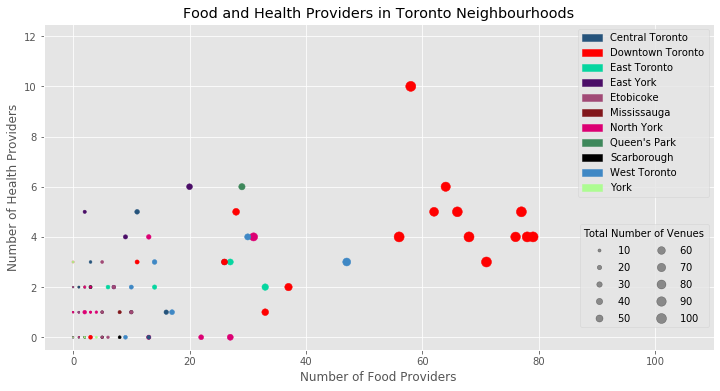

In [122]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

scatter = ax.scatter(x=venues_grouped['Food Provider'], 
                     y=venues_grouped['Health Provider'], 
                     s=venues_grouped['Venues'],
                     c=venues_grouped['Color'])

# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.4)
#handles, labels = scatter.legend_elements(prop="colors", alpha=0.4)
legend2 = ax.legend(handles, labels, bbox_to_anchor=(1, 0.4), loc='upper right', title="Total Number of Venues", ncol=2)
ax.add_artist(legend2)

patches = [ mpatches.Patch(color=color_set[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
plt.legend(handles=patches, bbox_to_anchor=(1, 1), loc='upper right', ncol=1)

plt.title('Food and Health Providers in Toronto Neighbourhoods')
plt.ylabel('Number of Health Providers')
plt.xlabel('Number of Food Providers')
plt.axis([-5, 110, -0.5, 12.5])

plt.savefig("toronto_scatter.png", format="png")

plt.show()

## Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [123]:
toronto_grouped = toronto_onehot.groupby(["PostalCode", "Borough", "Neighborhoods"]).mean().reset_index()

print(toronto_grouped.shape)
toronto_grouped.head()


(101, 6)


,PostalCode,Borough,Neighborhoods,Food Provider,Health Provider,Indifferent
0,M1B,Scarborough,"Rouge, Malvern",1.000000,0.000000,0.000000
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",0.333333,0.000000,0.666667
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",0.428571,0.000000,0.571429
3,M1G,Scarborough,Woburn,1.000000,0.000000,0.000000
4,M1H,Scarborough,Cedarbrae,0.714286,0.142857,0.142857


**Define the most represented venues category for each area**

In [124]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['PostalCode', 'Borough', 'Neighborhoods']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']
neighborhoods_venues_sorted['Borough'] = toronto_grouped['Borough']
neighborhoods_venues_sorted['Neighborhoods'] = toronto_grouped['Neighborhoods']

for ind in np.arange(toronto_grouped.shape[0]):
    row_categories = toronto_grouped.iloc[ind, :].iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 3:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted

(101, 6)


,PostalCode,Borough,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",Food Provider,Indifferent,Health Provider
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",Indifferent,Food Provider,Health Provider
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",Indifferent,Food Provider,Health Provider
3,M1G,Scarborough,Woburn,Food Provider,Indifferent,Health Provider
4,M1H,Scarborough,Cedarbrae,Food Provider,Indifferent,Health Provider
5,M1J,Scarborough,Scarborough Village,Indifferent,Health Provider,Food Provider
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",Indifferent,Food Provider,Health Provider
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",Indifferent,Food Provider,Health Provider
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",Indifferent,Food Provider,Health Provider
9,M1N,Scarborough,"Birch Cliff, Cliffside West",Health Provider,Indifferent,Food Provider


**Check the number of areas (by PostalCode) in two dataframes**

In [125]:
print(toronto_df_new.shape)
print(toronto_grouped.shape)

(102, 5)
(101, 6)


**Find the difference between dataframes**

In [126]:
a = toronto_df_new['PostalCode']
b = toronto_grouped['PostalCode']
dif = set(a) - set(b)
print(dif)

{'M9A'}


**Remove "empty" areas**

In [127]:
for d in dif:
    print(d)
    toronto_df_new = toronto_df_new[toronto_df_new.PostalCode != d]

print(toronto_df_new.shape)

M9A
(101, 5)


**Cluster Areas**

In [128]:
# set number of clusters
k = 3

toronto_grouped_clustering = toronto_grouped.drop(["PostalCode", "Borough", "Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 2, 2, 1, 1, 2, 2, 2, 2, 0], dtype=int32)

In [129]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
toronto_merged = toronto_df_new.copy()
#toronto_merged = toronto_df.copy()


# add clustering labels
toronto_merged["Cluster Labels"] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.drop(["Borough", "Neighborhoods"], 1).set_index("PostalCode"), on="PostalCode")

print(toronto_merged.shape)

# sort the results by Cluster Labels
toronto_merged.sort_values(["Cluster Labels"], inplace=True)
#toronto_merged.head()
toronto_merged


(101, 9)


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
74,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512,0,Health Provider,Food Provider,Indifferent
73,M6C,York,Humewood-Cedarvale,43.693781,-79.428191,0,Health Provider,Indifferent,Food Provider
36,M4C,East York,Woodbine Heights,43.695344,-79.318389,0,Health Provider,Indifferent,Food Provider
25,M3A,North York,Parkwoods,43.753259,-79.329656,0,Health Provider,Food Provider,Indifferent
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Health Provider,Food Provider,Indifferent
64,M5P,Central Toronto,"Forest Hill North, Forest Hill West",43.696948,-79.411307,0,Health Provider,Indifferent,Food Provider
79,M6L,North York,"Downsview, North Park, Upwood Park",43.713756,-79.490074,0,Health Provider,Food Provider,Indifferent
40,M4J,East York,East Toronto,43.685347,-79.338106,0,Indifferent,Health Provider,Food Provider
17,M2H,North York,Hillcrest Village,43.803762,-79.363452,0,Indifferent,Health Provider,Food Provider
33,M3N,North York,Downsview Northwest,43.761631,-79.520999,0,Health Provider,Food Provider,Indifferent


In [130]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# since the best clusters have three different categories as 1st common one, I define colors as ogange, green and blue
rainbow = ['green','orange','blue']

# add markers to the map
markers_colors = []
for lat, lon, post, bor, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['PostalCode'], toronto_merged['Borough'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup('{} ({}): {} - Cluster {}'.format(bor, post, poi, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.4).add_to(map_clusters)
    


map_clusters.save("map_clusters.html")    
       
map_clusters

toronto_grouped - sorted by postal code
toronto_merged - sorted by cluster
venues_grouped - sorted by postal code

**Examine Clusters**

*Cluster 1*

In [134]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0, 1,2] + list(range(5, toronto_merged.shape[1]))]]


,PostalCode,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
9,M1N,Scarborough,"Birch Cliff, Cliffside West",0,Health Provider,Indifferent,Food Provider
14,M1V,Scarborough,"Agincourt North, L'Amoreaux East, Milliken, St...",0,Indifferent,Health Provider,Food Provider
17,M2H,North York,Hillcrest Village,0,Indifferent,Health Provider,Food Provider
25,M3A,North York,Parkwoods,0,Health Provider,Food Provider,Indifferent
32,M3M,North York,Downsview Central,0,Indifferent,Health Provider,Food Provider
33,M3N,North York,Downsview Northwest,0,Health Provider,Food Provider,Indifferent
36,M4C,East York,Woodbine Heights,0,Health Provider,Indifferent,Food Provider
37,M4E,East Toronto,The Beaches,0,Health Provider,Food Provider,Indifferent
40,M4J,East York,East Toronto,0,Indifferent,Health Provider,Food Provider
44,M4N,Central Toronto,Lawrence Park,0,Health Provider,Indifferent,Food Provider


*Cluster 2*

In [135]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0, 1,2] + list(range(5, toronto_merged.shape[1]))]]


,PostalCode,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",1,Food Provider,Indifferent,Health Provider
3,M1G,Scarborough,Woburn,1,Food Provider,Indifferent,Health Provider
4,M1H,Scarborough,Cedarbrae,1,Food Provider,Indifferent,Health Provider
10,M1P,Scarborough,"Dorset Park, Scarborough Town Centre, Wexford ...",1,Food Provider,Indifferent,Health Provider
11,M1R,Scarborough,"Maryvale, Wexford",1,Food Provider,Indifferent,Health Provider
13,M1T,Scarborough,"Clarks Corners, Sullivan, Tam O'Shanter",1,Food Provider,Indifferent,Health Provider
15,M1W,Scarborough,L'Amoreaux West,1,Food Provider,Indifferent,Health Provider
19,M2K,North York,Bayview Village,1,Food Provider,Indifferent,Health Provider
20,M2L,North York,"Silver Hills, York Mills",1,Food Provider,Indifferent,Health Provider
21,M2M,North York,"Newtonbrook, Willowdale",1,Food Provider,Indifferent,Health Provider


*Cluster 3*

In [136]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0, 1,2] + list(range(5, toronto_merged.shape[1]))]]


,PostalCode,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",2,Indifferent,Food Provider,Health Provider
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",2,Indifferent,Food Provider,Health Provider
5,M1J,Scarborough,Scarborough Village,2,Indifferent,Health Provider,Food Provider
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",2,Indifferent,Food Provider,Health Provider
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",2,Indifferent,Food Provider,Health Provider
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",2,Indifferent,Food Provider,Health Provider
12,M1S,Scarborough,Agincourt,2,Indifferent,Food Provider,Health Provider
18,M2J,North York,"Fairview, Henry Farm, Oriole",2,Indifferent,Food Provider,Health Provider
23,M2P,North York,York Mills West,2,Indifferent,Health Provider,Food Provider
24,M2R,North York,Willowdale West,2,Indifferent,Food Provider,Health Provider
